# WQU Capstone project - Short-term trading strategy on G10 currencies
## Notebook six - Machine Learning - level 1 modells

* Sergey Chigrinov - chigrinov.s.88@gmail.com
* Dhruv Agraval -  dhruva1@stanfordalumni.org
* Man Sing Ho - mshoalbert@gmail.com

### Jun-Aug-2020

In [1]:
import sys
import os
#insert you own path or use relative path
path_to_project = os.path.realpath('..') # r'C:\WQU\Capstone\Working_files'
sys.path.append(path_to_project)

In [2]:
from WQUcapstoneCode.ml.ml import classifier_metrics, crossValPlot, PurgedKFold

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-talk')
plt.style.use('bmh')

In [5]:
from sklearn import datasets
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.calibration import calibration_curve
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [6]:
ticker = 'AUD/USD'

In [7]:
preprocessed_path= os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv')
data = pd.read_csv(preprocessed_path, index_col=0)
#data = data[data.bin!=0]

We need to split the data into training, validation and test sets. We may try using "purged k-fold cross validation", as in the book, however, our data is already not dense, so we may use just a regular cross validation to choose best modells.

In [8]:
all_feature_cols = data.columns[:-2]
frdif_feature_dict = {c[:-6]:c for c in all_feature_cols if c[-5:]=='frdif'}
ex_frdiff_cols = [c for c in all_feature_cols if c not in frdif_feature_dict.values()]
frdiff_cols = [c for c in all_feature_cols if c not in frdif_feature_dict.keys()]
side_cols = [c for c in all_feature_cols if c[-4:]=='side']

In [9]:
# split the data into 3 parts: ~50%, 25%, 25%
n = len(data)
train_ids, valid_ids, test_ids = (0, int(np.floor(n/2))), (int(np.ceil(n/2)), int(np.floor(n/2+n/4))), (int(np.ceil(n/2+n/4)), n)
train_ids, valid_ids, test_ids 

((0, 475), (475, 712), (713, 950))

In [10]:
X_train = data[all_feature_cols].iloc[train_ids[0]:train_ids[1],:]
X_valid = data[all_feature_cols].iloc[valid_ids[0]:valid_ids[1],:]
X_test = data[all_feature_cols].iloc[test_ids[0]:test_ids[1],:]

Y_train = data.bin.iloc[train_ids[0]:train_ids[1]]
Y_valid = data.bin.iloc[valid_ids[0]:valid_ids[1]]
Y_test = data.bin.iloc[test_ids[0]:test_ids[1]]
print(Y_train.value_counts())
print(Y_valid.value_counts())
print(Y_test.value_counts())

cols = list(frdiff_cols)
#cols.remove('Autocor_1_lag')
#cols = top_feat

-1.0    238
 1.0    237
Name: bin, dtype: int64
-1.0    133
 1.0    104
Name: bin, dtype: int64
 1.0    125
-1.0    112
Name: bin, dtype: int64


Later we may use one of GBMs to select important geatures. For now it's Random Forest

Tuning RandomForest

In [11]:
cols = all_feature_cols
RANDOM_STATE = 1
rfc = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                            random_state=RANDOM_STATE)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', .3, .1]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 8, num = 7)]#[int(x) for x in np.linspace(1, 40, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
cv = KFold(n_splits=4, shuffle=False)
search = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1)
search.fit(X_train[cols],Y_train)
rfc = search.best_estimator_
print(f'Best parameters:/n{search.best_params_}')

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.5min finished


Best parameters:/n{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 6}


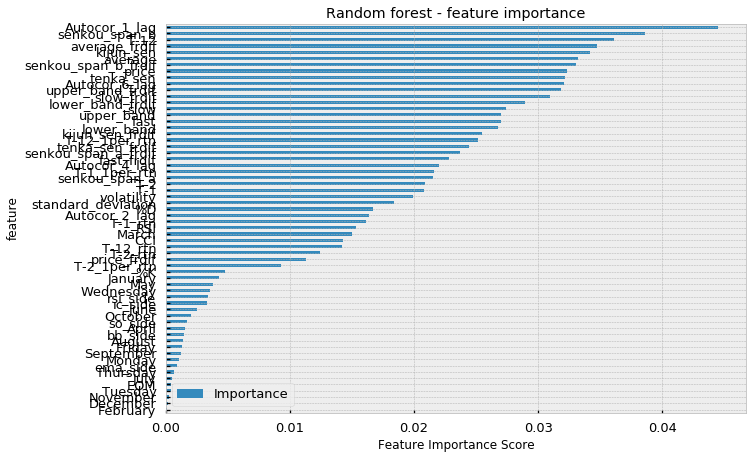

In [12]:
feat_imp = pd.DataFrame({'Importance':rfc.feature_importances_})    
feat_imp['feature'] = X_train[cols].columns
#feat_imp.sort_values(by='Importance', ascending=False, inplace=True)

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp[feat_imp.Importance>0].plot.barh(title='Random forest - feature importance')
plt.xlabel('Feature Importance Score')
plt.show()

We can select features that Random Forest assumes to be important

In [14]:
top_feat = feat_imp[feat_imp.Importance>0.01].index
top_feat

Index(['price_frdif', 'T-2_rtn', 'T-12_rtn', 'CCI', 'March', 'RSI', 'T-1_rtn',
       'Autocor_2_lag', '%D', 'standard_deviation', 'volatility', 'T-1', 'T-2',
       'senkou_span_a', 'T-1_1per_rtn', 'Autocor_4_lag', 'fast_frdif',
       'senkou_span_a_frdif', 'tenka_sen_frdif', 'T-12_1per_rtn',
       'kijun_sen_frdif', 'lower_band', 'fast', 'upper_band', 'slow',
       'lower_band_frdif', 'slow_frdif', 'upper_band_frdif', 'Autocor_6_lag',
       'tenka_sen', 'price', 'senkou_span_b_frdif', 'average', 'kijun_sen',
       'average_frdif', 'T-12', 'senkou_span_b', 'Autocor_1_lag'],
      dtype='object', name='feature')

In [15]:
features = {'all_feature_cols':all_feature_cols, 
            'ex_frdiff_cols':ex_frdiff_cols,
            'frdiff_cols':frdiff_cols, 
            'top_feat_RF':top_feat
           }

models = {'LightGBM':LGBMClassifier(), 
          'XGBoost':XGBClassifier(), 
         'Tuned RF':rfc,
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
          'ExtraTrees':ExtraTreesClassifier(random_state=RANDOM_STATE),
         'AdaBoost': AdaBoostClassifier(n_estimators=1000, random_state=0),
         'Scaler->PCA4->RF':make_pipeline(StandardScaler(),PCA(n_components=4),RandomForestClassifier(random_state=RANDOM_STATE)),
         'Scaler->PCA4->LogRegr': make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(max_iter=1000, tol=0.1)),
         'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', random_state=RANDOM_STATE)),
         'Scaler->PCA4->SVM': make_pipeline(StandardScaler(), PCA(n_components=4), svm.SVC(kernel='rbf', random_state=RANDOM_STATE)),
         'Scaler->PCA20->SVM': make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='rbf', random_state=RANDOM_STATE)),
         'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
          'Scaler->Naive Bayes':make_pipeline(StandardScaler(), GaussianNB())
         }                   

cv = KFold(n_splits=10, shuffle=False)

for n,cols in features.items():
    print('\n'+n)
    for m,c in models.items():
        n_scores = cross_val_score(c, X_train[cols], Y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
        print(f'{m} Accuracy: {np.mean(n_scores):.3f} (+/-{np.std(n_scores):.3f})')
#classifier_metrics(X_valid[cols], Y_valid, model.fit(X_train[cols], Y_train), False)


all_feature_cols
LightGBM Accuracy: 0.501 (+/-0.070)
XGBoost Accuracy: 0.497 (+/-0.052)
Tuned RF Accuracy: 0.508 (+/-0.054)
RF Accuracy: 0.495 (+/-0.050)
ExtraTrees Accuracy: 0.503 (+/-0.071)
AdaBoost Accuracy: 0.499 (+/-0.091)
Scaler->PCA4->RF Accuracy: 0.484 (+/-0.059)
Scaler->PCA4->LogRegr Accuracy: 0.533 (+/-0.092)
Scaler->SVM Accuracy: 0.452 (+/-0.074)
Scaler->PCA4->SVM Accuracy: 0.497 (+/-0.074)
Scaler->PCA20->SVM Accuracy: 0.478 (+/-0.059)
Scaler->PCA20->Naive Bayes Accuracy: 0.518 (+/-0.063)
Scaler->Naive Bayes Accuracy: 0.478 (+/-0.055)

ex_frdiff_cols
LightGBM Accuracy: 0.520 (+/-0.046)
XGBoost Accuracy: 0.470 (+/-0.039)
Tuned RF Accuracy: 0.508 (+/-0.060)
RF Accuracy: 0.476 (+/-0.049)
ExtraTrees Accuracy: 0.493 (+/-0.043)
AdaBoost Accuracy: 0.463 (+/-0.060)
Scaler->PCA4->RF Accuracy: 0.487 (+/-0.068)
Scaler->PCA4->LogRegr Accuracy: 0.514 (+/-0.077)
Scaler->SVM Accuracy: 0.457 (+/-0.067)
Scaler->PCA4->SVM Accuracy: 0.438 (+/-0.059)
Scaler->PCA20->SVM Accuracy: 0.444 (+/-0.04

So far the best modells are LightGBM, XGBoost , SVM, NB fitted using features selected by Random Forest on the first step. 
These model have the highest accuracy and lowest standard deviation. We need to check the details

In [16]:
cols = top_feat
models = {'LightGBM':LGBMClassifier(), 
          'XGBoost':XGBClassifier(), 
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
          'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
        'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', random_state=RANDOM_STATE))          
         }  
for m,c in models.items():
    c.fit(X_train[cols],Y_train)
    print(f'{m} - accuracy')
    Y_pred = c.predict(X_valid[cols])
    print('Validation set')
    print(confusion_matrix(Y_valid, Y_pred))    
    print(classification_report(Y_valid, Y_pred))
    Y_pred = c.predict(X_test[cols])
    print('Test set')
    print(confusion_matrix(Y_test, Y_pred))    
    print(classification_report(Y_test, Y_pred))
    print('-------------------------------------------------')    

LightGBM - accuracy
Validation set
[[91 42]
 [65 39]]
              precision    recall  f1-score   support

        -1.0       0.58      0.68      0.63       133
         1.0       0.48      0.38      0.42       104

    accuracy                           0.55       237
   macro avg       0.53      0.53      0.53       237
weighted avg       0.54      0.55      0.54       237

Test set
[[ 16  96]
 [ 13 112]]
              precision    recall  f1-score   support

        -1.0       0.55      0.14      0.23       112
         1.0       0.54      0.90      0.67       125

    accuracy                           0.54       237
   macro avg       0.55      0.52      0.45       237
weighted avg       0.54      0.54      0.46       237

-------------------------------------------------
XGBoost - accuracy
Validation set
[[91 42]
 [70 34]]
              precision    recall  f1-score   support

        -1.0       0.57      0.68      0.62       133
         1.0       0.45      0.33      0.38     

In [17]:
rfc = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                            random_state=RANDOM_STATE)
cols = frdiff_cols # all_feature_cols, ex_frdiff_cols, frdiff_cols
rfc.fit(X_train[cols],Y_train)
rfc.fit(X_valid[cols],Y_valid)
print('Random forest - test accuracy')
print(classification_report(Y_test, rfc.predict(X_test[cols])))
print(confusion_matrix(Y_test, rfc.predict(X_test[cols])))
print('Random forest - validation accuracy')
print(confusion_matrix(Y_valid, rfc.predict(X_valid[cols])))
#classifier_metrics(X_valid[cols], Y_valid, rfc, False)


Random forest - test accuracy
              precision    recall  f1-score   support

        -1.0       0.53      0.46      0.49       112
         1.0       0.57      0.64      0.60       125

    accuracy                           0.55       237
   macro avg       0.55      0.55      0.55       237
weighted avg       0.55      0.55      0.55       237

[[51 61]
 [45 80]]
Random forest - validation accuracy
[[133   0]
 [  0 104]]


Tuning LogisticRegression

In [17]:
#pca = PCA()
#pipe = make_pipeline(StandardScaler(),PCA(n_components=c), LogisticRegression(max_iter=1000, tol=0.1))
logistic = LogisticRegression(max_iter=1000, tol=0.1)
pipe = Pipeline(steps=[('Scaler',StandardScaler()),('pca',PCA()),('logistic',logistic)])

#logistic = LogisticRegression()
#pipe = make_pipeline(PCA(), LogisticRegression())
param_grid = {'pca__n_components':[6,9,20,30], 'logistic__C':np.logspace(-4,4,4)}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
search.fit(X_train[cols],Y_train)
logistic = search.best_estimator_
search.best_params_

{'logistic__C': 0.046415888336127774, 'pca__n_components': 6}

LogisticRegression - test accuracy
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       112
         1.0       0.53      1.00      0.69       125

    accuracy                           0.53       237
   macro avg       0.26      0.50      0.35       237
weighted avg       0.28      0.53      0.36       237

LogisticRegression - validation accuracy
              precision    recall  f1-score   support

        -1.0       0.57      0.75      0.65       133
         1.0       0.46      0.27      0.34       104

    accuracy                           0.54       237
   macro avg       0.51      0.51      0.49       237
weighted avg       0.52      0.54      0.51       237



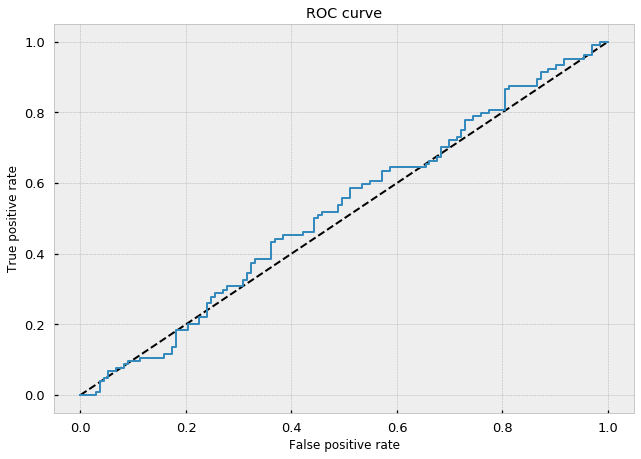

In [18]:
print('LogisticRegression - test accuracy')
print(classification_report(Y_test, logistic.predict(X_test[cols])))
print('LogisticRegression - validation accuracy')
classifier_metrics(X_valid[cols], Y_valid, logistic, False)

AdaBoost - test accuracy
              precision    recall  f1-score   support

        -1.0       0.73      0.07      0.13       112
         1.0       0.54      0.98      0.70       125

    accuracy                           0.55       237
   macro avg       0.63      0.52      0.41       237
weighted avg       0.63      0.55      0.43       237

AdaBoost - validation accuracy
              precision    recall  f1-score   support

        -1.0       0.57      0.69      0.63       133
         1.0       0.46      0.34      0.39       104

    accuracy                           0.54       237
   macro avg       0.52      0.51      0.51       237
weighted avg       0.52      0.54      0.52       237



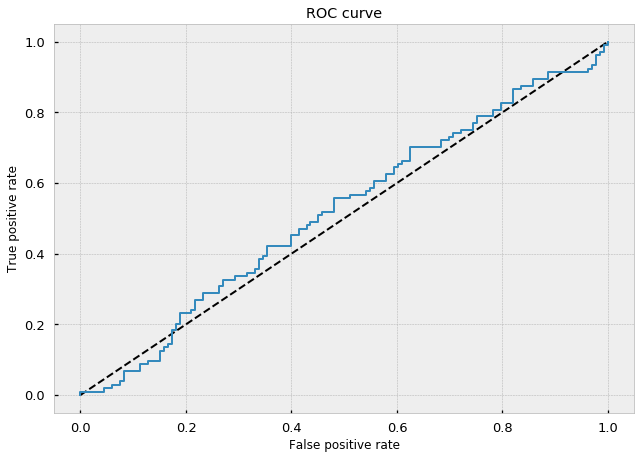

In [19]:
ada = AdaBoostClassifier(n_estimators=1000, random_state=0)
ada.fit(X_train[cols],Y_train)
print('AdaBoost - test accuracy')
print(classification_report(Y_test, ada.predict(X_test[cols])))
print('AdaBoost - validation accuracy')
classifier_metrics(X_valid[cols], Y_valid, ada, False)

Naive Bayes - test accuracy
              precision    recall  f1-score   support

        -1.0       0.22      0.04      0.06       112
         1.0       0.51      0.89      0.65       125

    accuracy                           0.49       237
   macro avg       0.36      0.46      0.35       237
weighted avg       0.37      0.49      0.37       237

Naive Bayes - validation accuracy
              precision    recall  f1-score   support

        -1.0       0.58      0.71      0.64       133
         1.0       0.48      0.34      0.40       104

    accuracy                           0.55       237
   macro avg       0.53      0.53      0.52       237
weighted avg       0.54      0.55      0.53       237



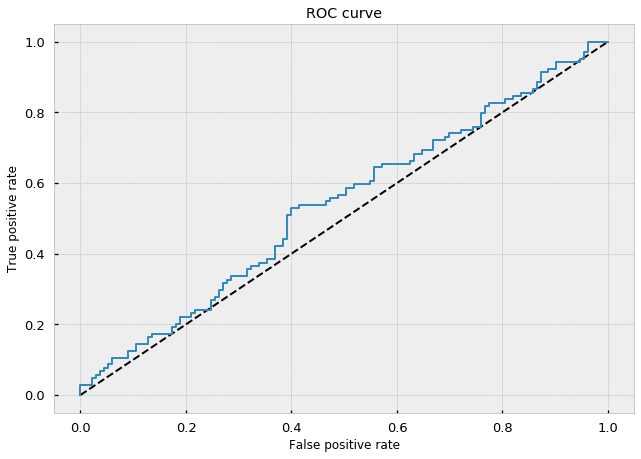

In [20]:
gnb = make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB())
gnb.fit(X_train[cols],Y_train)
print('Naive Bayes - test accuracy')
print(classification_report(Y_test, gnb.predict(X_test[cols])))
print('Naive Bayes - validation accuracy')
classifier_metrics(X_valid[cols], Y_valid, gnb, False)

SVM - test accuracy
              precision    recall  f1-score   support

        -1.0       0.45      0.55      0.50       112
         1.0       0.49      0.39      0.44       125

    accuracy                           0.47       237
   macro avg       0.47      0.47      0.47       237
weighted avg       0.47      0.47      0.47       237

SVM - validation accuracy
              precision    recall  f1-score   support

        -1.0       0.55      0.73      0.63       133
         1.0       0.41      0.24      0.30       104

    accuracy                           0.51       237
   macro avg       0.48      0.48      0.47       237
weighted avg       0.49      0.51      0.49       237



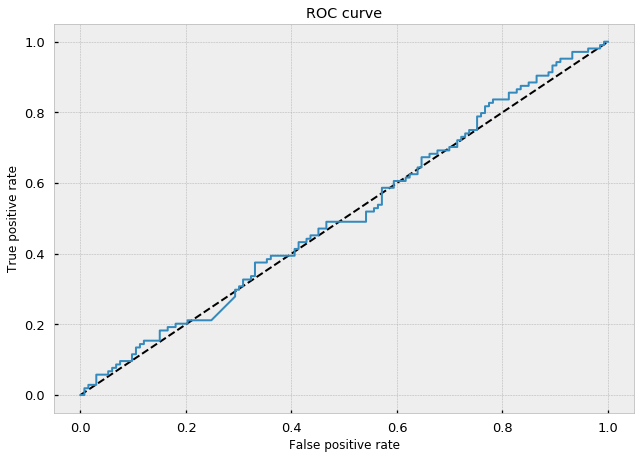

In [21]:
svm_rbf = make_pipeline(StandardScaler(), PCA(5), svm.SVC(kernel='rbf', probability=True))
svm_rbf.fit(X_train[cols],Y_train)
print('SVM - test accuracy')
print(classification_report(Y_test, svm_rbf.predict(X_test[cols])))
print('SVM - validation accuracy')
classifier_metrics(X_valid[cols], Y_valid, svm_rbf, False)

In [22]:
gnb = make_pipeline(StandardScaler(), PCA(n_components=20), GaussianNB())
svc = make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='linear', random_state=RANDOM_STATE))
#lsvc = make_pipeline(StandardScaler(), PCA(n_components=20), svm.LinearSVC(max_iter=1000, probability=True))
svm_rbf =  make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', gamma=0.7, probability=True))
svm_poly = make_pipeline(StandardScaler(), svm.SVC(kernel='poly', degree=3, gamma='auto', probability=True))
#knn = KNeighborsClassifier()

estimators=[('Logistic', logistic), 
#            ('Naive Bayes', gnb), 
#            ('Linear SVC', lsvc), 
            ('SVM_rbf',svm_rbf), 
            ('Random Forest',rfc),
            ('AdaBoost',ada)
#            ('knn',knn)
           ]
for name, clf  in estimators:
    clf.fit(X_train[cols], Y_train)
    print(f'{name} train: {accuracy_score(Y_train, clf.predict(X_train[cols]))}')
    print(f'{name} test: {accuracy_score(Y_valid, clf.predict(X_valid[cols]))}')

test_voting = True
if test_voting:
    best_valid = 0
    best_test = 0
    best_wt = []
    for i in range(10):
        wt = [np.random.normal(RANDOM_STATE) for _ in estimators]   
        vc = VotingClassifier(estimators,weights=wt, voting = 'hard')
        vc.fit(X_valid[cols], Y_valid)
        #print(f'\nweights={wt}')
        score_valid = accuracy_score(Y_valid, vc.predict(X_valid[cols]))
        score_test = accuracy_score(Y_test, vc.predict(X_test[cols]))
        #print(f'Voting train: {score_valid}')
        #print(f'Voting test: {score_valid}')
        #if ((score_valid + score_test) > (best_valid + best_test)) and (best_test>0.5):
        if ((score_test) > (best_test)):
            best_valid, best_test = score_valid, score_test
            best_wt = wt
    print(f'\nweights={best_wt}')
    print(f'Voting train: {best_valid}')
    print(f'Voting test: {best_test}')

Logistic train: 0.5663157894736842
Logistic test: 0.540084388185654
SVM_rbf train: 1.0
SVM_rbf test: 0.5654008438818565
Random Forest train: 0.7663157894736842
Random Forest test: 0.5527426160337553
AdaBoost train: 1.0
AdaBoost test: 0.5358649789029536

weights=[0.898568442425667, 1.7365135486998482, 1.961401752440286, 1.4062869723875107]
Voting train: 1.0
Voting test: 0.540084388185654


In [23]:
vc = VotingClassifier(estimators, voting = 'soft')
vc.fit(X_valid[use_columns], Y_valid)
score_valid = accuracy_score(Y_valid, clf.predict(X_valid[cols]))
score_test = accuracy_score(Y_test, vc.predict(X_test[cols]))
print(f'Voting train: {score_valid}')
print(f'Voting test: {score_test}')
print(accuracy_score(Y_train, vc.predict(X_train[cols])))

NameError: name 'use_columns' is not defined

In [ ]:
y_pred = make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', gamma=0.7, probability=True)).fit(X_train,Y_train).predict_proba(X_test)
df = pd.concat([Y_test,pd.DataFrame(y_pred, index=Y_test.index)], axis=1)
breakeven_prob = 0.6
df.loc[df[0]>breakeven_prob,'forecast'] = -1
df.loc[df[1]>breakeven_prob,'forecast'] = 1
#df = df.dropna()
#print(classification_report(df.bin, df.forecast))
df